In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('model/')
from mlp import *
from tqdm import tqdm
import itertools
from utils import *
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from simple_agent import *
from simple_surrogate import *
from buffer import *
from surrogate_environment import *
import scipy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

%load_ext autoreload
%autoreload 2
#plt.style.use('dark_background')

plt.style.use('seaborn-deep')

#### Similar to the toy case, this notebook provides an example on the AC tuning on a synthetic study.  
#### Here, an AC model is pretrained on a fraction of the available data and then tries to optimize its performance on a sample from an unkonwn day.  
#### The synthetic environment is provided by a surrogate model which is trained on all data and inferred without gradient computation.  

# Set parameters

In [3]:
surrogate_num_hidden = 1
agent_num_hidden = 1
# Optimization learning rates
agent_lr = 1e-6
surrogate_lr = 1e-5

# Initalize seperate Buffer, agent external (testing)
experiences = Buffer(50000)

smooth_states = True
norm_states = True

# Normalization as agent feature
norm_feature = False
clip_norm = False
minmax_norm=False

# Activation function in last layer
last_layer_act_agent=True
last_layer_act_surrogate=True

x_vals_setting = np.load('setting_x_values.npy')
x_vals_spectrum = np.load('spectrum_x_values.npy')

norm_power = False

# Loading phase

In [4]:
states, base_actions = get_data(smooth_states=smooth_states, norm_states = norm_states, norm_power=norm_power)
start_states = states[:,:int(states.shape[1]/2)]
next_states = states[:,int(states.shape[1]/2):]
base_surrogate_states = torch.cat([start_states, base_actions], dim=1)
surrogate_actions = next_states

actions, xn, xp = get_pwl_actions(base_actions.float().to(device))
surrogate_states, xn, xp = get_pwl_surrogate_states(base_surrogate_states)

pre_states, base_pre_actions = get_data(smooth_states=smooth_states, norm_states = norm_states, train_with_live_data=False, norm_power=norm_power)
pre_start_states = pre_states[:,:int(pre_states.shape[1]/2)]
pre_next_states = pre_states[:,int(pre_states.shape[1]/2):]
base_pre_surrogate_states = torch.cat([pre_start_states, base_pre_actions], dim=1)
pre_surrogate_actions = pre_next_states

pre_actions, xn, xp = get_pwl_actions(base_pre_actions.float().to(device), base_waves=base_actions[:,1:])
pre_surrogate_states, xn, xp = get_pwl_surrogate_states(base_pre_surrogate_states, base_waves=base_actions[:,1:])

In [5]:
last_layer_act_agent=True
agent_num_hidden = 1
surrogate_num_hidden_ = 1

In [6]:
agent = SimpleAgent(input_size=states[0].shape[0], target_size=actions[0].shape[0], hidden_size=512, num_hidden=agent_num_hidden, activation = torch.sigmoid, lr=agent_lr, last_layer_activation = last_layer_act_agent, norm = norm_feature,  clip_norm = clip_norm, minmax_norm=minmax_norm,xn=xn, xp=xp)
surrogate = SimpleSurrogate(target_size=surrogate_actions[0].shape[0], hidden_size=512, num_hidden=surrogate_num_hidden_, activation = torch.tanh, lr=surrogate_lr, last_layer_activation = last_layer_act_surrogate, input_size=surrogate_states.shape[1])

# Trained with reduced data
agent_name = "pwl_noloopfix_data_fix_512_1_20000000_3s3fnhtx_noble-cosmos-257"
# Trained with reduced data
surrogate_name = "loop_data_fix_512_1_10000000_2394w3v7_gentle-feather-265"
# Trained with full data
pt_surrogate_name = 'loop_data_fix_512_1_10000000_31x86z8h_beloved-sweetheart-263'

agent.agent.load_state_dict(torch.load("historic_data/models/" +agent_name))
surrogate.model.load_state_dict(torch.load("historic_data/surrogates/"+surrogate_name))

env_surrogate_act = torch.tanh
env_surrogate = SimpleSurrogate(target_size=surrogate_actions[0].shape[0], input_size=surrogate_states.shape[1], hidden_size=512, num_hidden=surrogate_num_hidden, activation = env_surrogate_act, lr=surrogate_lr, last_layer_activation = last_layer_act_surrogate)
env_surrogate.model.load_state_dict(torch.load('historic_data/surrogates/'+ pt_surrogate_name, map_location=device))

<All keys matched successfully>

In [7]:
showcase = False

In [8]:
# Showcase: the surrogate model only knows the samples 0-45
if showcase:
    surrogate_out = surrogate.model(surrogate_states.float().to(device))
    for i in range(44,49):
        plt.title(i)
        plt.plot(surrogate_out[i].cpu().detach().numpy(),label='Prediction')
        plt.plot(surrogate_actions[i].cpu().detach().numpy(),label='GT')
        plt.legend()
        plt.show()

In [9]:
# Showcase: the environment model only knows all samples
if showcase:
    surrogate_out = env_surrogate.model(surrogate_states.float().to(device))
    for i in range(pre_start_states.shape[0]+112,pre_start_states.shape[0]+115):
        plt.plot(surrogate_out[i].cpu().detach().numpy(),label='Prediction')
        plt.plot(surrogate_actions[i].cpu().detach().numpy(),label='GT')
        plt.legend()
        plt.show()

In [10]:
# Showcase: the agent model only knows the samples 0-45
if showcase:
    agent.agent.pwl = True
    agent_out_base_full = agent.agent(states.float().to(device)).cpu().detach().numpy()
    for i in range(40,70):
        plt.title(i)
        plt.plot(agent_out_base_full[i])
        plt.plot(base_actions[i].cpu().detach().numpy())
        plt.show()

# multi-single target study

In [11]:
agent_lr = 1e-6
surrogate_lr = 1e-5

savety_check =  False

plot_data = []

100%|██████████| 5000/5000 [00:22<00:00, 222.04it/s, Explore loss=0.00337]


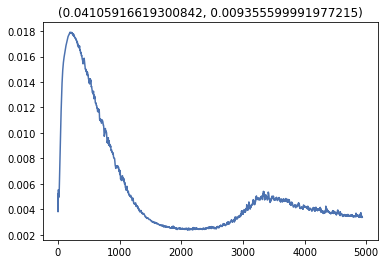

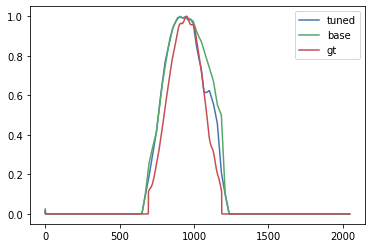

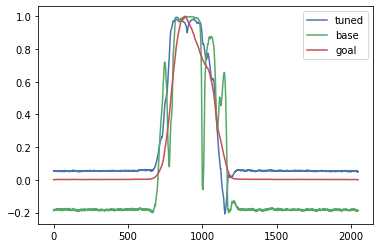

100%|██████████| 5000/5000 [00:22<00:00, 222.92it/s, Explore loss=0.00585]


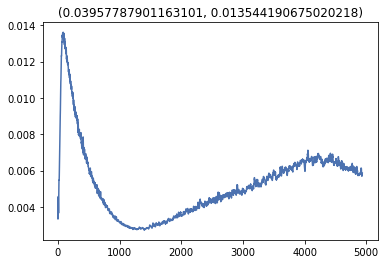

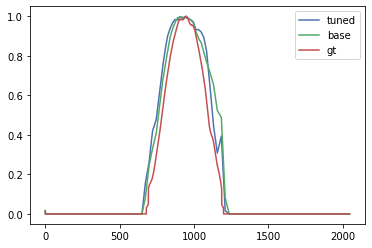

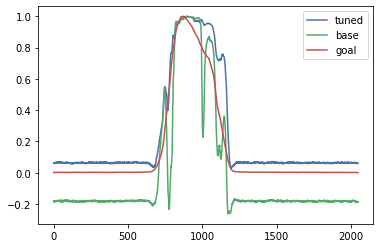

In [12]:
# Train for 2 samples respectively
improvement_track = []
for idx in range(pre_start_states.shape[0],48):# states.shape[0]):
    start = states[idx,:2048].unsqueeze(0).float().to(device)
    goal = states[idx,2048:].unsqueeze(0).float().to(device)
    action = base_actions[idx].unsqueeze(0).float().to(device)
    
    agent = SimpleAgent(input_size=states[0].shape[0], target_size=actions[0].shape[0], hidden_size=512, num_hidden=agent_num_hidden, activation = torch.sigmoid, lr=agent_lr, last_layer_activation = last_layer_act_agent, norm = norm_feature,  clip_norm = clip_norm, minmax_norm=minmax_norm,xn=xn, xp=xp)
    surrogate = SimpleSurrogate(target_size=surrogate_actions[0].shape[0], hidden_size=512, num_hidden=surrogate_num_hidden_, activation = torch.tanh, lr=surrogate_lr, last_layer_activation = last_layer_act_surrogate, input_size=surrogate_states.shape[1])
    agent.agent.load_state_dict(torch.load("historic_data/models/" +agent_name))
    surrogate.model.load_state_dict(torch.load("historic_data/surrogates/"+surrogate_name))
    
    env = Environment(targets=goal, state=start, surrogate=env_surrogate, savety_check=savety_check)
    tuned_state_base = agent.inference(1,env).unsqueeze(0)
    agent.agent.pwl = True
    agent_out_base_full = agent.agent(states[idx].unsqueeze(0).float().to(device)).cpu().detach().numpy()[0]
    agent.agent.pwl = False
    agent_out_base = agent.agent(states[idx].unsqueeze(0).float().to(device)).cpu().detach().numpy()[0]
    
    agent.experiences.vip_state_memory = pre_start_states.float().to(device) 
    agent.experiences.vip_action_memory = pre_actions.float().to(device)
    agent.experiences.vip_next_state_memory = pre_next_states.float().to(device)
    agent.experiences.vip_org_target_memory = pre_next_states.float().to(device) 

    train_params = {'batch_size':64, 'update_every':1}
    loss = []

    env = Environment(targets=goal, state=start, surrogate=env_surrogate, savety_check=savety_check)

    loss = loss + agent.explore(env, num_episodes= 5000, episode_len=1, train_params=train_params, surrogate=surrogate, prior=False, ssim=False, smooth_state=False)
    
    tuned_state_optim = agent.inference(1,env).unsqueeze(0)
    
    improvement_track.append((agent.loss_f(goal,tuned_state_base).item(),agent.loss_f(goal,tuned_state_optim).item()))
    agent.agent.pwl = True
    agent_out_tuned_full = agent.agent(states[idx].unsqueeze(0).float().to(device)).cpu().detach().numpy()[0]
    plt.title(improvement_track[-1])
    plt.plot(loss)
    plt.show()
    plt.plot(agent_out_tuned_full, label='tuned')
    plt.plot(agent_out_base_full, label='base')
    plt.plot(action.cpu().detach().numpy()[0], label='gt')
    plt.legend()
    plt.show()
    plt.plot(tuned_state_optim.cpu().detach().numpy()[0],label='tuned')
    plt.plot(tuned_state_base.cpu().detach().numpy()[0],label='base')
    plt.plot(goal.cpu().detach().numpy()[0],label='goal')
    plt.legend()
    plt.show()
    
        
    plot_data.append([[agent_out_tuned_full, 
                       agent_out_base_full,
                       action.cpu().detach().numpy()[0]],
                      [tuned_state_optim.cpu().detach().numpy()[0],
                       tuned_state_base.cpu().detach().numpy()[0],
                       goal.cpu().detach().numpy()[0]]])
#plt.show()

## Initial vs Tuned: Setting and Spectrum

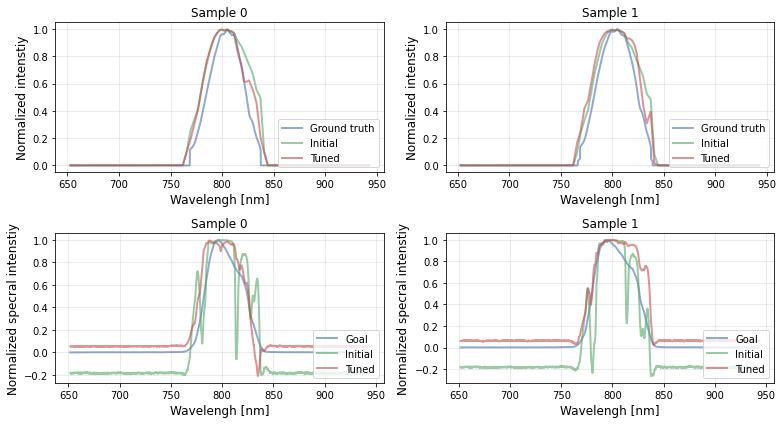

In [13]:
alpha=0.6
lw=2
fig, ax = plt.subplots(2,2,figsize=(11,6))
for i in range(2):
    ax[0,i].plot(x_vals_setting, plot_data[i][0][2][1:], label='Ground truth', alpha=alpha, lw=lw)
    ax[0,i].plot(x_vals_setting, plot_data[i][0][1][1:], label='Initial', alpha=alpha, lw=lw)
    ax[0,i].plot(x_vals_setting, plot_data[i][0][0][1:], label='Tuned', alpha=alpha, lw=lw)
    ax[0,i].legend(loc="lower right")
    ax[0,i].grid(alpha=0.3)
    ax[0,i].set_ylabel("Normalized intenstiy", size=12)
    ax[0,i].set_xlabel("Wavelengh [nm]", size=12)
    ax[0,i].set_title("Sample {}".format(i))

for i in range(2):
    ax[1,i].plot(x_vals_spectrum, plot_data[i][1][2], label='Goal', alpha=alpha, lw=lw)
    ax[1,i].plot(x_vals_spectrum, plot_data[i][1][1], label='Initial', alpha=alpha, lw=lw)
    ax[1,i].plot(x_vals_spectrum, plot_data[i][1][0], label='Tuned', alpha=alpha, lw=lw)
    ax[1,i].legend(loc="lower right")
    ax[1,i].grid(alpha=0.3)
    ax[1,i].set_ylabel("Normalized specral intenstiy", size=12)
    ax[1,i].set_xlabel("Wavelengh [nm]", size=12)
    ax[1,i].set_title("Sample {}".format(i))
plt.tight_layout()
plt.show()

## Quanitive plot

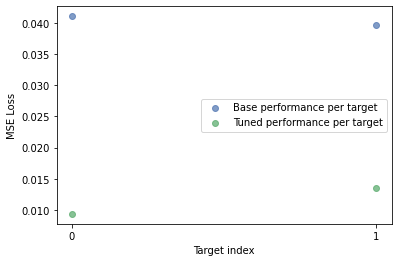

In [14]:
plt.scatter(np.arange(len(improvement_track)),np.array(improvement_track)[:,0], alpha=0.7, label="Base performance per target")
plt.scatter(np.arange(len(improvement_track)),np.array(improvement_track)[:,1], alpha=0.7, label="Tuned performance per target")
plt.xticks(np.arange(len(improvement_track)))
plt.xlabel("Target index")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()